# Implements encoder/decoder for weak lensing outputs

In [ ]:
# extract tarfiles if necessary and set specs for run

In [2]:
import os
use_COLAB = 1

if use_COLAB == 1:
  #mount drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)

  #get GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

Mounted at /content/gdrive
Mon Nov 13 23:02:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

In [3]:

import tarfile
import os
import shutil
from astropy.io import fits
import numpy as np
from scipy.ndimage import zoom
import re
import tensorflow as tf
import random


# Specify the directory containing the .tar files
directory_path = './columbialensing/'


max_cosmologies = -1 #for testing.  Set to -1 to use everything.

number_batches = 10
#validation_split = 0.4  # use this fraction of the data for validation
normalize_by_RMS = False #set to one if you want to renormalize by RMS



# image_size
image_size = 1024 #really makes sense to use the 1024s
sub_image_size = 64 #needs to divide image size
number_subimages_across =image_size//sub_image_size


number_fits_files = 512
suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}"

#extracts only if indicated (could make this more elegant by checking to see if they exist)
if extract_tarfiles:
    # Use a regular expression to match .tar files with the desired suffix
    pattern = re.compile(rf"{suffix}.tar$")

    # List all matching .tar files in the directory
    all_tar_files = [f for f in os.listdir(directory_path) if pattern.search(f)]

    # Extract the tar archive
    for tar_file in all_tar_files:
        #print(tar_file)
        tar_file_path = os.path.join(directory_path, tar_file)
        with tarfile.open(tar_file_path, 'r') as archive:
            archive.extractall(path=directory_path)


# Read into memory the data

In [4]:
def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]


#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
#all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]
all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_fits_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float16)
for idy, dir_name in enumerate(all_directories):
    if max_cosmologies>0 and idy >= max_cosmologies:
        break

    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]

    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]
WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension

reading in Om0.268_si0.801
RMS=0.016497720032930374


In [ ]:
#Just testing arrays

get_labels_for_file('Om0.264_si0.768_256')

print(tf.shape(WL_tensor))



tf.Tensor([131072     64     64      1], shape=(4,), dtype=int32)


# create decoder-encoder models with minimal number of layers



In [27]:
from tensorflow.keras import layers, models, regularizers
from keras.layers import LeakyReLU, BatchNormalization, Dropout

#Parameters for network
n=2 #number of layers (needs to be >2)
number_channels = 64
dropout_rate = 0

L1weight = 0 #1e-8
act_string = LeakyReLU(alpha=0.1) #okay, not a string

#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_d{dropout_rate }_logL1w{exponent}'

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

def create_simple_encoder(input_shape, n,  number_channels=number_channels, dropout_rate=dropout_rate):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels//2, (3, 3), activation=act_string, padding='same',\
              kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels, (3, 3), activation=act_string, padding='same',\
                  kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        if dropout_rate >0:
          model.add(Dropout(dropout_rate))

    # Adding a Dense layer for encoding
    model.add(layers.Flatten())
    model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_string, \
              kernel_regularizer=regularizer))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))

    return model


def create_simple_decoder(encoded_length, original_shape, n, number_channels=number_channels, dropout_rate=dropout_rate):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer((encoded_length,)))



    # Expanding the flat array to a 3D tensor
    model.add(layers.Dense(units=np.prod(encoded_length*number_channels), activation=act_string,\
              kernel_regularizer=regularizer))

    # Calculate the dimensions for the first reshape
    # It should match the output size of the last MaxPooling layer in the encoder
    reshape_dims = (original_shape[0] // (2 ** n), original_shape[1] // (2 ** n), number_channels)

    model.add(layers.Reshape(reshape_dims))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n):
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=act_string, padding='same',\
                  kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.UpSampling2D((2, 2)))
        if dropout_rate >0:
          model.add(Dropout(dropout_rate))

    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation=act_string, padding='same',\
                                     kernel_regularizer=regularizer))
    model.add(layers.UpSampling2D((2, 2)))
    if dropout_rate >0:
        model.add(Dropout(dropout_rate))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same',\
      kernel_regularizer=regularizer))

    return model



original_shape = [sub_image_size, sub_image_size, 1]


encoded_length = sub_image_size*sub_image_size//int(4**n)

load_saved = 1

model_name = f'simple_encoder_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    from tensorflow.keras.models import load_model
    simple_encoder = load_model(model_name)
    simple_decoder = load_model(f'simple_decoder_{save_string}.keras')
else:
  if load_saved == 1 and not os.path.exists(model_name):
      print(f"Path does not exist to {model_name}.  Creating model")
  simple_encoder = create_simple_encoder(original_shape , n)
  simple_decoder = create_simple_decoder(encoded_length,original_shape, n)


# Combine the encoder and decoder to create the autoencoder
simple_autoencoder = models.Sequential([simple_encoder, simple_decoder])



Path does not exist to simple_encoder_n2_nc64_d0_logL1w+00.keras.  Creating model


In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras import backend as K



# Set the learning rate (I find that .005 is too large)
learning_rate = 0.001

class RegularizationLossMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        regularization_loss = sum(self.model.losses)
        total_loss = logs['loss']
        data_loss = total_loss - regularization_loss
        print(f'\n Regularization loss: {regularization_loss:.4f}',)
        print(f'Data loss: {data_loss:.4f}',)
        print(f'Total loss: {total_loss:.4f}')


reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=5, min_lr=0.0002)

simple_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae") #loss=fractional_difference_loss) #, run_eagerly=True)

simple_encoder.summary()
simple_decoder.summary()




Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_36 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                     

In [29]:

simple_autoencoder.fit(WL_tensor, WL_tensor,
                epochs=40,
                batch_size=256,
                shuffle=True, callbacks=[reduce_lr]) #, RegularizationLossMonitor()  If inlclude RegularizationLossMonitor() as a callback, separately prints regularization loss at the end of each batch

Epoch 1/40
512/512 [==============================] - 11s 18ms/step - loss: 0.0077 - lr: 0.0010
Epoch 2/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0056 - lr: 0.0010
Epoch 3/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0050 - lr: 0.0010
Epoch 4/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0047 - lr: 0.0010
Epoch 5/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0044 - lr: 0.0010
Epoch 6/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0043 - lr: 0.0010
Epoch 7/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0042 - lr: 0.0010
Epoch 8/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0041 - lr: 0.0010
Epoch 9/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0040 - lr: 0.0010
Epoch 10/40
512/512 [==============================] - 9s 18ms/step - loss: 0.0040 - lr: 0.0010
Epoch 11/40
512/512 [===========================

In [8]:
simple_encoder.save(f'encoder_{save_string}.keras')
simple_decoder.save(f'decoder_{save_string}.keras')

# This takes out the dense layers  and makes a pure CNN encoder-decoder

In [9]:
from tensorflow.keras import layers, models, regularizers
from keras.layers import LeakyReLU, BatchNormalization, Dropout

#Parameters for network
n=4 #number of layers (needs to be >2)
number_channels = 256
number_final_channels = 64
dropout_rate = 0

L1weight = 1e-8
act_string = LeakyReLU(alpha=0.1) #okay, not a string

#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_nfc{number_final_channels}_d{dropout_rate }_logL1w{exponent}'

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

def create_CNN_encoder(input_shape, n,  number_channels=number_channels, dropout_rate=dropout_rate):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels//2, (3, 3), activation=None, padding='same',\
              kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(layers.Activation(act_string))
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate >0:
      model.add(Dropout(dropout_rate))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels, (3, 3), activation=None, padding='same',\
                  kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.Activation(act_string))
        model.add(layers.MaxPooling2D((2, 2)))
        if dropout_rate >0:
          model.add(Dropout(dropout_rate))

    # Adding a Dense layer for encoding

    model.add(layers.Conv2D(number_final_channels, (1, 1), activation=None, padding='same',\
          kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(layers.Activation(act_string))
    if dropout_rate >0:
        model.add(Dropout(dropout_rate))


    #model.add(layers.Flatten())
    #model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_string, \
    #          kernel_regularizer=regularizer))

    return model


def create_CNN_decoder(original_shape, n, number_channels=number_channels, dropout_rate=dropout_rate):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer( (original_shape[0] // (2 ** n), original_shape[1] // (2 ** n), number_final_channels)))

    model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation=None, padding='same',\
                  kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(layers.Activation(act_string))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n):
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=None, padding='same',\
                  kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.Activation(act_string))
        model.add(layers.UpSampling2D((2, 2)))
        if dropout_rate >0:
          model.add(Dropout(dropout_rate))

    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation=None, padding='same',\
                                     kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(layers.Activation(act_string))

    model.add(layers.UpSampling2D((2, 2)))
    if dropout_rate >0:
        model.add(Dropout(dropout_rate))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same',\
      kernel_regularizer=regularizer))

    return model



original_shape = [sub_image_size, sub_image_size, 1]


load_saved = 1

model_name = f'CNN_encoder_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    from tensorflow.keras.models import load_model
    CNN_encoder = load_model(model_name)
    CNN_decoder = load_model(f'simple_decoder_{save_string}.keras')
else:
  if load_saved == 1 and not os.path.exists(model_name):
      print(f"Path does not exist to {model_name}.  Creating model")
  CNN_encoder = create_CNN_encoder(original_shape, n)
  CNN_decoder = create_CNN_decoder(original_shape, n)


# Combine the encoder and decoder to create the autoencoder
CNN_autoencoder = models.Sequential([CNN_encoder, CNN_decoder])



Path does not exist to CNN_encoder_n4_nc256_nfc64_d0_logL1w-08.keras.  Creating model


In [10]:
CNN_encoder.summary()
CNN_decoder.summary()

learning_rate = .001

CNN_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       1280      
                                                                 
 batch_normalization_2 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 64, 64, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 256)      

In [11]:
CNN_autoencoder.fit(WL_tensor, WL_tensor,
                epochs=40,
                batch_size=256,
                shuffle=True, callbacks=[reduce_lr]) #, RegularizationLossMonitor()  If inlclude RegularizationLossMonitor() as a callback, separately prints regularization loss at the end of each batch

Epoch 1/40
512/512 [==============================] - 55s 93ms/step - loss: 0.0204 - lr: 0.0010
Epoch 2/40
512/512 [==============================] - 47s 93ms/step - loss: 0.0083 - lr: 0.0010
Epoch 3/40
512/512 [==============================] - 47s 93ms/step - loss: 0.0077 - lr: 0.0010
Epoch 4/40
512/512 [==============================] - 47s 93ms/step - loss: 0.0073 - lr: 0.0010
Epoch 5/40
512/512 [==============================] - 47s 93ms/step - loss: 0.0072 - lr: 0.0010
Epoch 6/40
512/512 [==============================] - 47s 93ms/step - loss: 0.0068 - lr: 0.0010
Epoch 7/40
512/512 [==============================] - 47s 93ms/step - loss: 0.0066 - lr: 0.0010
Epoch 8/40
512/512 [==============================] - 47s 92ms/step - loss: 0.0063 - lr: 0.0010
Epoch 9/40
512/512 [==============================] - 47s 93ms/step - loss: 0.0064 - lr: 0.0010
Epoch 10/40
512/512 [==============================] - 47s 93ms/step - loss: 0.0063 - lr: 0.0010
Epoch 11/40
512/512 [==================

In [12]:
CNN_encoder.save(f'CNN_encoder_{save_string}.keras')
CNN_decoder.save(f'CNN_decoder_{save_string}.keras')

#This now is the same CNN with residual connections

In [21]:
from tensorflow.keras import layers, models, regularizers
from keras.layers import LeakyReLU, BatchNormalization, Dropout

number_channels = 64
dropout_rate = 0

L1weight = 1e-8
act_string = LeakyReLU(alpha=0.1) #okay, not a string



# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None


#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_d{dropout_rate }_logL1w{exponent}'


def create_encoder_residconnect(input_shape, n, number_channels=number_channels, act_string=act_string, dropout_rate=0, regularizer=regularizer):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Initial Convolutional Layer
    x = layers.Conv2D(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act_string)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    # Additional Layers with Residual Connections
    for _ in range(1, n):
        identity = x
        x = layers.Conv2D(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(act_string)(x)
        x = layers.Conv2D(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Add()([x, identity])  # Residual Connection
        x = layers.Activation(act_string)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)

    # Flatten and Dense Layer
    x = layers.Flatten()(x)
    x = layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_string, kernel_regularizer=regularizer)(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    model = models.Model(inputs, x)
    return model

def create_decoder_residconnect(encoded_length, original_shape, n, number_channels=number_channels, act_string=act_string, dropout_rate=0, regularizer=regularizer):
    inputs = layers.Input(shape=(encoded_length,))
    x = inputs

    # Dense layer
    x = layers.Dense(units=np.prod(encoded_length*number_channels), activation=act_string, kernel_regularizer=regularizer)(x)
    x = layers.Reshape((original_shape[0] // (2 ** n), original_shape[1] // (2 ** n), number_channels))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act_string)(x)

    # Upsampling Layers with Residual Connections
    for _ in range(1, n):
        identity = x
        x = layers.Conv2DTranspose(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(act_string)(x)
        x = layers.Conv2DTranspose(number_channels, (3, 3), activation=None, padding='same', kernel_regularizer=regularizer)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Add()([x, identity])  # Residual Connection
        x = layers.Activation(act_string)(x)
        x = layers.UpSampling2D((2, 2))(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)

    # Final Conv2DTranspose to get back to original shape
    x = layers.Conv2DTranspose(number_channels, (3, 3), activation=act_string, padding='same', kernel_regularizer=regularizer)(x)
    x = layers.UpSampling2D((2, 2))(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same', kernel_regularizer=regularizer)(x)

    model = models.Model(inputs, x)
    return model




n=2 #number of layers (needs to be >2)
original_shape = [sub_image_size, sub_image_size, 1]
encoded_length = sub_image_size*sub_image_size//int(4**n)

load_saved = 1
model_name = f'encoder_residconnect_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    from tensorflow.keras.models import load_model
    encoder_residconnect= load_model(f'encoder_residconnect_{save_string}.keras')
    decoder_residconnect = load_model(f'decoder_residconnect_{save_string}.keras')

else:
  if load_saved == 1 and not os.path.exists(model_name):
        print(f"Path does not exist to {model_name}.  Creating model")
  encoder_residconnect = create_encoder_residconnect(original_shape , n)
  decoder_residconnect = create_decoder_residconnect(encoded_length,original_shape, n)

# Combine the encoder and decoder to create the autoencoder
autoencoder_residconnect = models.Sequential([encoder_residconnect, decoder_residconnect])

encoder_residconnect.summary()
decoder_residconnect.summary()

Path does not exist to encoder_residconnect_n2_nc64_d0_logL1w-08.keras.  Creating model
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 64, 64, 64)           640       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_30 (Ba  (None, 64, 64, 64)           256       ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 act

In [22]:
# Set the learning rate
learning_rate = 0.001


# Combine the encoder and decoder to create the autoencoder
autoencoder_residconnect = models.Sequential([encoder_residconnect, decoder_residconnect])
#autoencoder_residconnect.summary()

autoencoder_residconnect.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae")

autoencoder_residconnect.fit(WL_tensor, WL_tensor,
                epochs=40,
                batch_size=256,
                shuffle=True, callbacks=[reduce_lr]) #, RegularizationLossMonitor()

Epoch 1/40
512/512 [==============================] - 22s 36ms/step - loss: 0.0278 - lr: 0.0010
Epoch 2/40
512/512 [==============================] - 19s 36ms/step - loss: 0.0108 - lr: 0.0010
Epoch 3/40
512/512 [==============================] - 19s 36ms/step - loss: 0.0096 - lr: 0.0010
Epoch 4/40
512/512 [==============================] - 19s 36ms/step - loss: 0.0085 - lr: 0.0010
Epoch 5/40
512/512 [==============================] - 19s 36ms/step - loss: 0.0082 - lr: 0.0010
Epoch 6/40
512/512 [==============================] - 19s 36ms/step - loss: 0.0082 - lr: 0.0010
Epoch 7/40
512/512 [==============================] - 19s 36ms/step - loss: 0.0075 - lr: 0.0010
Epoch 8/40
512/512 [==============================] - 19s 36ms/step - loss: 0.0072 - lr: 0.0010
Epoch 9/40
512/512 [==============================] - 19s 37ms/step - loss: 0.0068 - lr: 0.0010
Epoch 10/40
512/512 [==============================] - 19s 36ms/step - loss: 0.0068 - lr: 0.0010
Epoch 11/40
512/512 [==================

In [23]:
encoder_residconnect.save(f'encoder_residconnect _{save_string}.keras')
decoder_residconnect.save(f'decoder_residconnect _{save_string}.keras')

## More complex model

In [43]:
from tensorflow.keras import layers, models


number_channels = 64

act_func = LeakyReLU(alpha=0.1)

L1weight = 0 #1e-8

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None


#string with parameters for saving
sci_notation = "{:.0e}".format(L1weight)
exponent = sci_notation.split('e')[-1]
save_string = f'n{n}_nc{number_channels}_d{dropout_rate }_logL1w{exponent}'


def create_encoder(input_shape, n, number_channels=64, act_string=act_string, regularizer=regularizer):
    if n<2:
        print("n is too small.  n >=2")

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape))

    model.add(layers.Conv2D(number_channels//2, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.Conv2D(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    for nlayer in range(1,n):
        model.add(layers.Conv2D(number_channels, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.Conv2D(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(layers.Conv2D(number_channels, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    # Adding a Dense layer for encoding
    model.add(layers.Flatten())
    model.add(layers.Dense(units=(input_shape[0] * input_shape[1]) // (4 ** n), activation=act_func, kernel_regularizer=regularizer))

    return model


def create_decoder(encoded_length, original_shape, n, number_channels=64, act_string=act_string, regularizer=regularizer):
    model = models.Sequential()

    # The input is a flat array
    model.add(layers.InputLayer((encoded_length,)))



    # Expanding the flat array to a 3D tensor
    model.add(layers.Dense(units=np.prod(encoded_length*64), activation=act_func, kernel_regularizer=regularizer))


    # Calculate the dimensions for the first reshape
    # It should match the output size of the last MaxPooling layer in the encoder
    reshape_dims = (original_shape[0] // (2 ** n), original_shape[1] // (2 ** n), 64)

    model.add(layers.Reshape(reshape_dims))

    # Upsampling to original size, looping over number of layers
    for nlayer in range(1, n):
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
        model.add(layers.Conv2DTranspose(number_channels, (3, 3), activation=act_func, padding='same'))
        model.add(BatchNormalization())
        model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2DTranspose(number_channels, (1, 1), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.Conv2DTranspose(number_channels/2, (3, 3), activation=act_func, padding='same', kernel_regularizer=regularizer))
    model.add(layers.UpSampling2D((2, 2)))

    # Final layer to reconstruct the image
    model.add(layers.Conv2D(original_shape[2], (1, 1), activation='linear', padding='same', kernel_regularizer=regularizer))

    return model





n=2 #number of layers (needs to be >2)
original_shape = [sub_image_size, sub_image_size, 1]


encoded_length = sub_image_size*sub_image_size//int(4**n)

load_saved = 0
model_name = f'encoder_{save_string}.keras'
if load_saved == 1 and os.path.exists(model_name):
    encoder= load_model(f'encoder_{save_string}.keras')
    decoder = load_model(f'decoder_{save_string}.keras')
else:
    if load_saved == 1 and not os.path.exists(model_name):
        print(f"Path does not exist to {model_name}.  Creating model...")
    # Combine the encoder and decoder to create the autoencoder
    encoder = create_encoder(original_shape , n)
    decoder = create_decoder(encoded_length,original_shape, n)

autoencoder = models.Sequential([encoder, decoder])



In [44]:
from tensorflow.keras.optimizers import Adam
from keras import backend as K


# Set the learning rate
learning_rate = 0.001

# Create an Adam optimizer with the desired learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

def fractional_difference_loss(y_true, y_pred):
    # Avoid division by zero
    epsilon = .01 # A small, non-zero number to prevent division by zero
    # Calculate the fractional difference
    loss = K.mean(K.abs((y_pred - y_true) / (K.abs(y_true) + epsilon)), axis=-1)
    return loss

def fractional_square_loss(y_true, y_pred):
    # Avoid division by zero
    epsilon = 1e-2 # A small, non-zero number to prevent division by zero
    # Calculate the fractional difference
    loss = K.square((y_pred - y_true) / (K.abs(y_true) + epsilon))
    return loss

encoder.summary()
decoder.summary()

autoencoder.compile(optimizer='adam', loss="mae") #loss=fractional_difference_loss) #, run_eagerly=True)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 64)        2112      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_46 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 64)      

# train simple CNN

In [45]:
print(WL_tensor.shape)

#encoded = encoder(WL_tensor[:256, :, :, :])
#decoder(encoded)

autoencoder.fit(WL_tensor, WL_tensor,
                epochs=40,
                batch_size=256,
                shuffle=True, callbacks=[reduce_lr])

(131072, 64, 64, 1)
Epoch 1/40
512/512 [==============================] - 22s 35ms/step - loss: 0.0157 - lr: 0.0010
Epoch 2/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0089 - lr: 0.0010
Epoch 3/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0072 - lr: 0.0010
Epoch 4/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0071 - lr: 0.0010
Epoch 5/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0058 - lr: 0.0010
Epoch 6/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0055 - lr: 0.0010
Epoch 7/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0052 - lr: 0.0010
Epoch 8/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0051 - lr: 0.0010
Epoch 9/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0050 - lr: 0.0010
Epoch 10/40
512/512 [==============================] - 18s 35ms/step - loss: 0.0049 - lr: 0.0010
Epoch 11/40
512/512

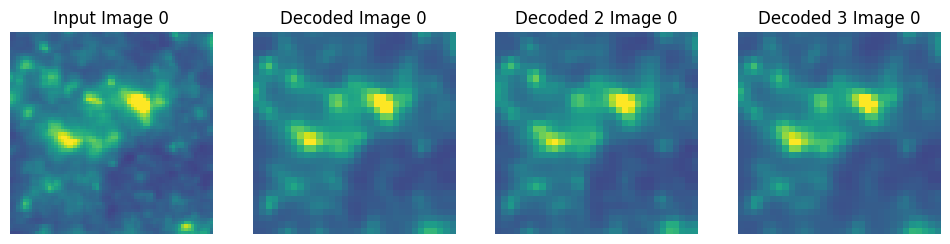

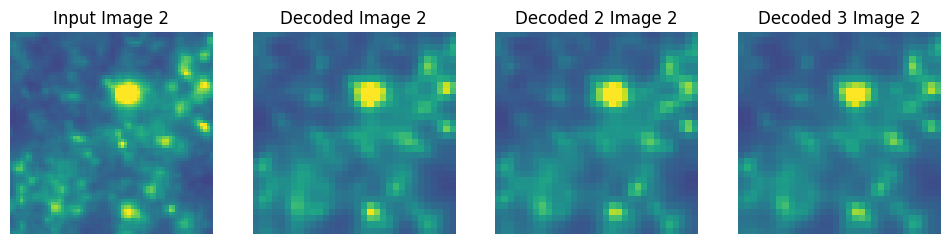

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming WL_tensor is a 4D tensor with shape (num_images, height, width, channels)
# and sub_image_size is the size of the second and third dimensions (height and width).
num_images = 5
sub_image_size = WL_tensor.shape[1]  # Assuming height and width are the same

number_decoders = 3

# Get the outputs from the decoder
decoded_images1 = simple_decoder(simple_encoder(WL_tensor[:num_images,...])).numpy()

if number_decoders >= 2:
  decoded_images2 = CNN_decoder(CNN_encoder(WL_tensor[:num_images,...])).numpy()
if number_decoders >=3:
    decoded_images3 = decoder_residconnect(encoder_residconnect(WL_tensor[:num_images,...])).numpy()
if number_decoders >=4:
    decoded_images4 = decoder(encoder(WL_tensor[:num_images,...])).numpy()

# Function to display images
def display_side_by_side(index):
    if index < 0 or index >= num_images:
        raise ValueError("Index out of bounds")

    # Select the specific input and output images
    input_image = WL_tensor[index, :, :, 0]  # Assuming grayscale, channel dimension is 0
    output_image1 = decoded_images1[index, :, :, 0]  # Also assuming grayscale

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, number_decoders+1, figsize=(4*number_decoders, 10))

    # Display the input image in the first subplot
    axes[0].imshow(input_image, cmap='viridis', vmin=-0.05, vmax=.1)
    axes[0].set_title(f'Input Image {index}')
    axes[0].axis('off')  # Hide the axis

    # Display the output image in the second subplot
    axes[1].imshow(output_image1, cmap='viridis', vmin=-0.05, vmax=.1)
    axes[1].set_title(f'Decoded Image {index}')
    axes[1].axis('off')  # Hide the axis

    if number_decoders >=2:
      # Display the output image in the second subplot
      output_image2 = decoded_images2[index, :, :, 0]  # Also assuming grayscale
      axes[2].imshow(output_image2, cmap='viridis', vmin=-0.05, vmax=.1)
      axes[2].set_title(f'Decoded 2 Image {index}')
      axes[2].axis('off')  # Hide the axis

    if number_decoders >=3:
      # Display the output image in the second subplot
      output_image3 = decoded_images3[index, :, :, 0]  # Also assuming grayscale
      axes[3].imshow(output_image3, cmap='viridis', vmin=-0.05, vmax=.1)
      axes[3].set_title(f'Decoded 3 Image {index}')
      axes[3].axis('off')  # Hide the axis


    if number_decoders >=4:
      # Display the output image in the second subplot
      output_image4 = decoded_images4[index, :, :, 0]  # Also assuming grayscale
      axes[3].imshow(output_image4, cmap='viridis', vmin=-0.05, vmax=.1)
      axes[3].set_title(f'Decoded 4 Image {index}')
      axes[3].axis('off')  # Hide the axis

    # Display the images
    plt.show()


# Example usage for the first image
display_side_by_side(0)  # You can loop or call this function for other indices as well
display_side_by_side(2)